Este experimento consiste en variar los parametros $maxdf$ y $mindf$ para ver con cuales obtenemos un modelo de **Bag of Words** con las palabras que contengan la mayor cantidad de 'sentimiento'. Nuestra hipótesis es que conservando las palabras que aparecen de forma muy frecuentes incluiremos muchos pronombres o conectores del lenguaje y estas tienen poco 'sentimiento' lo que empeorara los resultados. Y al incluir palabras con poca frecuencia de aparición, conservamos palabras que aparecen poco pero tienen alta carga de 'sentimiento' mejorando los resultados

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

#Cargo datos
df = pd.read_csv('../data/imdb_small.csv')

#Separo datos entrenamiento y datos prueba
trainSize = 5000
testSize = 1000

trainData = df[df.type == 'train'].sample(n=trainSize, random_state=123)
testData = df[df.type == 'test'].sample(n=testSize, random_state=456)

text_train = trainData["review"]
label_train = trainData["label"]

text_test = testData["review"]
label_test = testData["label"]

In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(text_train)
bow = vectorizer.transform(text_train)

sum_words = bow.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [19]:
words_freq[:10]

[('the', 67801),
 ('and', 33202),
 ('of', 29272),
 ('to', 27271),
 ('is', 21272),
 ('br', 20904),
 ('it', 19431),
 ('in', 19042),
 ('this', 14990),
 ('that', 14597)]

In [20]:
words_freq[-10:]

[('earpeircing', 1),
 ('barbaric', 1),
 ('tres', 1),
 ('lancashire', 1),
 ('donate', 1),
 ('dolman', 1),
 ('sphincters', 1),
 ('overrides', 1),
 ('blakey', 1),
 ('borefest', 1)]

In [2]:
import sentiment
from tqdm import tqdm_notebook as tqdm

In [4]:
maxDfs = [1.-i/100 for i in range(16)]
minDfs = [i/100 for i in range(16)]

data = []

#Barra de progreso
#pip3 install tqdm ipywidgets
#jupyter nbextension enable --py widgetsnbextension

pbar = tqdm(total=len(maxDfs)*len(minDfs))
for maxDf in maxDfs:
    for minDf in minDfs:
        #max_df muy alto = peor?
        #min_df bajo = mejor?
        vectorizer = CountVectorizer(max_df=maxDf, min_df=minDf, max_features=5000)
        vectorizer.fit(text_train)

        #Transformo al modelo BoW los datos
        X_train, y_train = vectorizer.transform(text_train).toarray(), (label_train == 'pos').values
        X_test, y_test = vectorizer.transform(text_test).toarray(), (label_test == 'pos').values
        for k_percentage in range(1, 101):
            pbar.set_description('{} {} {}'.format(maxDf, minDf, X_train.shape[1]))
            k = max(round(trainSize*k_percentage/100), 1)

            knn = sentiment.KNNClassifier(k)
            knn.fit(X_train, y_train)

            y_pred = knn.predict(X_test)
            acc = accuracy_score(y_test, y_pred)

            data.append((maxDf, minDf, X_train.shape[1], k_percentage, acc))
            pbar.update(.01)
pbar.close()

In [11]:
df = pd.DataFrame(data, columns = ['max_df', 'min_df', 'features', 'k', 'acc'])

In [12]:
df.to_csv('experimentoMaxMinDf')

In [3]:
df = pd.read_csv('experimentoMaxMinDf')

In [4]:
maxAcc = df.groupby(['max_df', 'min_df']).max().reset_index()
maxAcc = maxAcc.pivot('max_df', 'min_df', 'acc')

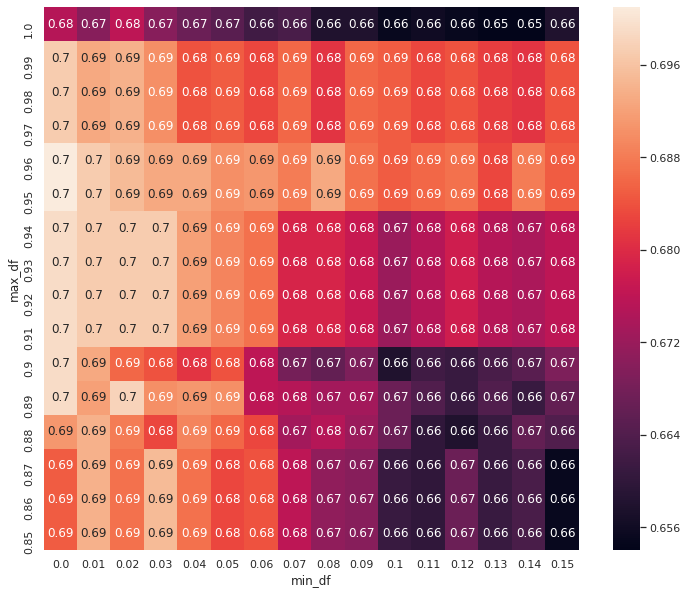

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
plt.figure(figsize=(12, 10))
ax = sns.heatmap(maxAcc,  annot=True)
ax.set_ylim(16, 0)
ax.invert_yaxis()

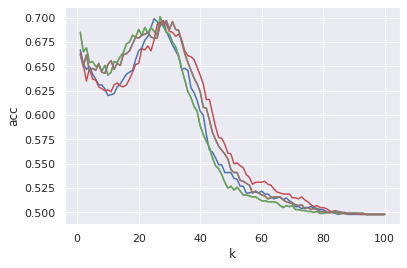

In [34]:
ax = sns.lineplot(x="k", y="acc", data=df[(df.max_df == 0.94)&(df.min_df == 0.)])
ax = sns.lineplot(x="k", y="acc", data=df[(df.max_df == 0.95)&(df.min_df == 0.)])
ax = sns.lineplot(x="k", y="acc", data=df[(df.max_df == 0.96)&(df.min_df == 0.)])
ax = sns.lineplot(x="k", y="acc", data=df[(df.max_df == 0.94)&(df.min_df == 0.01)])
ax = sns.lineplot(x="k", y="acc", data=df[(df.max_df == 0.95)&(df.min_df == 0.01)])
ax = sns.lineplot(x="k", y="acc", data=df[(df.max_df == 0.96)&(df.min_df == 0.01)])